---
# Solving Stochastic Differential Equations using Monte Carlo Simulation
**Christian Lyng (TQS500) & Lasse Trap-Hinge (QJW189)**

## Introduction

The structure of classic theoretical models within finance, such as the Black-Scholes-Merton model or interest rate models, was often developed with an analytic tractability in mind. However, a growing derivatives market and competition within the financial field creates incentives to develop more advanced models that closer reflects the actual market behavior. One downside of this is that the model complexity increases which reduces the analytical tractability, thus making the models difficult to apply and therefore heavily reliant on numerical solutions such as the Monte Carlo methods. 

In this model analysis project we seek to investigate the application of the Monte Carlo methods non-solveable stochastic differential equations (SDEs) where we will primarily focus on the one-factor square root diffusion model of the short rate, the Cox-Ingersoll-Ross model.

## The The Cox-Ingersoll-Ross Model

The Cox-Ingersoll-Ross (CIR) model is a diffusion process that solves the stochastic differential equation 

$$dr_t=a(b-r_t)dt+\sigma \sqrt{r_t}dW_t \tag{1}$$

where $a$, $b$ and $\sigma$ are positive constants, $W_t$ is a Brownian motion under the risk-neutral probability measure $\mathcal{Q}$ and $r_t$ is the risk-free short rate at time $t$, sometimes also referred to as the instantaneous short rate. 

The model has a mean-reverting drift to a level of $b$ at a rate of $a$ and has zero probability of generating negative interest rates due to the level dependent volatility term $\sigma \sqrt{r_t}$. This is genereally considered a realistic feature of the model, but the last few years have shown that interest rate can become negative. Nonetheless, bit with this in mind, we will use the CIR model for the remainder of this model analysis project. 

The CIR model should be sufficiently complicated to illustrate how SDEs can be simulated and the problems arising by doing so, but more important, the CIR model have an analytical solution, so we can evalutate the Monte Carlo methods by comparing the numerical estimates with the actual model solution.

The analytic solution to the CIR model is given as

$$P(t,T)=A(t,T)e^{-B(t,T)r(t)}\tag{2}$$
where
$$A(t,T)= \left[ \frac{2\eta e^{(\eta+a)(T-t)/2}}{(\eta+a)(e^{\eta(T-t)}-1)+2\eta}\right]^{2ab/\sigma^2}$$
and
$$B(t,T)=\frac{2(e^{\eta(T-t)}-1)}{(\eta+a)(e^{\eta(T-t)}-1)+2\eta}$$
and
$$\eta=\sqrt{a^2+2\sigma^2}$$ 

$P(t,T)$ denotes the price of a discount bond at time $t$ maturing at time $T$ where we set the price at time $t=0$ to be $P(0,T)=1$ for simplicity. 

The applied Monte Carlo methods in this model analysis project can then be extended to other more complicated models.

## The Euler Discretization Scheme

If we are dealing with complex models that we cannot solve, one solution is to do an approximate simulation. One of the simplest way to do this is by using the Euler discreatization scheme. The two SDEs we consider in this project, one for the interest rate and one for the discount bond price, is formally written as

$$dr_t = \mu(r_t)dt + \sigma (r_t)dW_t \tag{i}$$

and

$$dI_t = -r_t I_t dt\tag{ii}$$ 

Please note that $I_t$ denotes the discount bond price at time $t$ which is set to 1 at time $t=0$. 

Considering the SDEs in $(i)$ and $(ii)$, we can apply CIR model and expand these in a first-order Ito-Taylor series. We descretize the CIR process into equidistant time steps of length $h = T/n$ where $T$ is the time of maturity and $n$ is the number of steps. Skipping the derivations for now to focus on doing model analysis, the Euler discretization scheme for the CIR model can be shown to be

$$r_{t+1}=r_t + a(b-r_t)h+\sigma\sqrt{r_t^+ h}Z \tag{3}$$ 

$$I_{t+1}=I_t(1-r_t h)\tag{4}$$

for the interest rate and the discount bond price, respectively. We have taken the precaution to use the max operator to aviod errors in the form of negative values in the volatility when using the discretized version of the CIR model, denoted $r_t^+$. Moreover, we have that $Z \sim \mathcal{N}(0,1)$ and $h=T/n$.

We can then use $(3)$ and $(4)$ to create sample paths of $r_t$ and $I_t$.

## Methodology

To showcase the methodology we are trying to apply, we construct a simple example.

In [5]:
#Import necessary packages
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline

We then create a function that simulates sample paths of $r_t$ and $I_t$.

In [6]:
#Define the function
def cir_euler(r0, a, b, sigma, T, n, m):
    
    np.random.seed(844)
    h = T/n
    r = np.empty([n+1, m])
    I = np.empty([n+1, m])
    r[0,:] = r0
    I[0,:] = 1
    cols_r_euler = []
    cols_I_euler = []
    
    for j in range(m):
        
        #Create columns for dataframe
        cols_r_euler.append('r_path_' + str(j+1))
        cols_I_euler.append('I_path_' + str(j+1))
        
        for i in range(n):
            
            r[i+1,j]=r[i,j]+a*(b-r[i, j])*h+sigma*math.sqrt(max(r[i,j],0))*math.sqrt(h)*np.random.normal()
            I[i+1,j]=I[i,j]*(1-r[i,j]*h)
            
    return pd.DataFrame(r, columns = cols_r_euler), pd.DataFrame(I, columns = cols_I_euler)

To run the function we have to set the model parameters:

In [7]:
#Set parameters
r0 = 0.025 #Interest rate at time t = 0
a = 0.2 
b = 0.025
sigma = 0.1
T = 1 #Maturity
n = 100 #Number of steps
m = 3 #Number of sample paths of r and I

Given the above set parameters, we create 3 paths of $r_t$ and $I_t$

In [8]:
#Run the cir_euler function and store results
r, I = cir_euler(r0, a, b, sigma, T, n, m);

#Merge the output from cir_euler into one dataframe
sample_paths = pd.concat([r,I], axis = 1)

#Show some paths
sample_paths.head(n = 11)

,r_path_1,r_path_2,r_path_3,I_path_1,I_path_2,I_path_3
0,0.025000,0.025000,0.025000,1.000000,1.000000,1.000000
1,0.025894,0.026659,0.025119,0.999750,0.999750,0.999750
2,0.026258,0.024439,0.023178,0.999491,0.999483,0.999499
3,0.027119,0.024972,0.024839,0.999229,0.999239,0.999267
4,0.026030,0.025203,0.023444,0.998958,0.998990,0.999019
5,0.025748,0.023588,0.021793,0.998698,0.998738,0.998785
6,0.028112,0.022067,0.017850,0.998441,0.998502,0.998567
7,0.027651,0.020556,0.018539,0.998160,0.998282,0.998389
8,0.027151,0.020353,0.018997,0.997884,0.998077,0.998204
9,0.026669,0.017685,0.017971,0.997613,0.997874,0.998014


From the above table we see that the interest rate paths are set to start at $2.5\%$ and the discount bond price at $1$. The interest rate then follows random walks and the discount bond price is dependent on these random walks.

To make the evolution of these paths clearer we plot the sample paths from above:

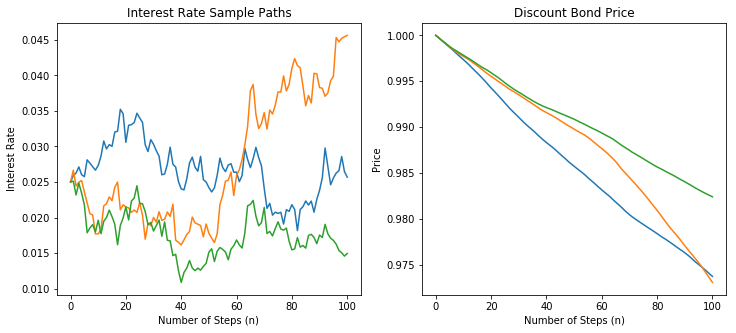

In [9]:
#Create a figure
fig = plt.figure(figsize = (12,5))

#Adjust and plot the interest rate figure
ax_left = fig.add_subplot(1,2,1)
ax_left.set_title('Interest Rate Sample Paths')
ax_left.set_ylabel('Interest Rate')
ax_left.set_xlabel('Number of Steps (n)')
ax_left.plot(r);

#Adjust and plot the discount bond price figure
ax_right = fig.add_subplot(1,2,2)
ax_right.set_title('Discount Bond Price')
ax_right.set_ylabel('Price')
ax_right.set_xlabel('Number of Steps (n)')
ax_right.plot(I);

The figures above show the relationship between the interest rate and the value of the discount bond. On the left figure we see three random walks of the interest rate. When the interest rate increases the discount bond price drops. Notice how one interest rate path initially is low or around the starting value, but spike up for $n$ close to $100$ and how the discount price is negatively affected by this.

To evaluate the numerical application, we construct a numerical estimate of the discount bond price by taking the average of the sample paths at time $T$ (at the last step, above example would be at $n = 100$). More formally, we have that

$$\hat{P}(t,T)=\frac{1}{m}\sum^{m}_{j=1} I_{Tj}\tag{5}$$

where $j$ denotes the $j$th path of the discount bond price. 

We examine the accuracy by calculating the mean absolute error

$$MAE=|\hat{P}(t,T)-P(t,T)|\tag{6}$$

where $\hat{P}(t,T)$ is the numerical estimate found in $(5)$ and $P(t,T)$ is the CIR model's analytical solution found in $(2)$.

We now examine the numerical estimate from the above simulated sample paths.

In [10]:
#Calcualte the numerical estimate as the mean of the discount bond price at time T
num_estimate = np.mean(I.iloc[-1,:])

#Calculate the analytical solution found in (2)
eta = np.sqrt(a**2+2*sigma**2)
A = (2*eta*np.exp((a+eta)*T/2)/((eta+a)*(np.exp(eta*T)-1)+2*eta))**(2*a*b/(sigma**2))
B = 2*(np.exp(eta*T)-1)/((eta+a)*(np.exp(eta*T)-1)+2*eta)
P = A*np.exp(-r0*B)

#Calcualte the mean absolute error
MAE = abs(num_estimate-P)

print('Numerical Estimate: 'f'{num_estimate:.5f}')
print('Theoretical value: 'f'{P:.5f}')
print('Mean Absolute Error: 'f'{MAE:.5f}')

Numerical Estimate: 0.97638
Theoretical value: 0.97534
Mean Absolute Error: 0.00103


We see that by only simulating three sample paths, but with a quite large $n$ and thus closer to continous time than a lower value of $n$, we get a numerical estimate that is quite close the theoretical value, displayed from a mean absolute error of 0.00103. 

For later analysis, we note that the mean absolute error can be split into a systematic error and a statistical error

$$MAE = MAE_{sys} + MAE_{stat}$$

where $MAE_{sys} \rightarrow 0$ as $n\rightarrow\infty $, i.e. for very large $n$, the mean absolute error will only consist of statistical noise and the numerical discount bond price estimate will converge to the theoretical value given by the analytical solution.

 ## Simulation of the Euler Scheme
 
 Given the quite simple example shown so far, we seek to extend the analysis by eximining how accurate the numerical estimate is when varying the number of steps, $n$.
 
 We do this by creating a function that loops over the already defined function, cir_euler, with varying values of $n$. At first, we set the parameter values we wish to use:

In [11]:
#Set parameters
r0 = 0.005
a = 0.4
b = 0.05
sigma = 0.1
T = 2
n_list = [2**x for x in range(9)] #Create a list of n's
m = 10000

Note that we create a list of values for $n$ instead of specifying one value. Here, we decided to create a function so each new value of $n$ added to the list will be doubled compared to the latest value, but starting at $n = 1$. Moreover, the starting value of the interest rate is set to $0.5\%$ which is realistic considering the low yield environment since the financial crisis. We have chosen to simulate 10,000 paths of the interest rate which should be sufficient for consistent results. Below we create a function to loop over n_list:

In [12]:
def cir_euler_output():
    
    MAE_euler = np.empty([len(n_list), 1])
    
    eta = np.sqrt(a**2+2*sigma**2)
    A = (2*eta*np.exp((a+eta)*T/2)/((eta+a)*(np.exp(eta*T)-1)+2*eta))**(2*a*b/(sigma**2))
    B =  2*(np.exp(eta*T)-1)/((eta+a)*(np.exp(eta*T)-1)+2*eta)
    P = A*np.exp(-r0*B)
        
    for number in range(0,len(n_list)):
        
        n = n_list[number]
        res_r_euler, res_I_euler = cir_euler(r0, a, b, sigma, T, n, m)
        mean = np.mean(res_I_euler.iloc[-1,:])
        
        #Mean absolute error
        MAE_euler[number] = abs(mean - P)
        
    return pd.DataFrame(MAE_euler, columns = ['Mean Absolute Error'], index = n_list) 

We then create a table of the mean absolute error

In [13]:
#Create a dataframe of the output
output_euler = pd.DataFrame(cir_euler_output())
output_euler.index.name = 'n'

#Display the output
output_euler.head(n = len(n_list))

,Mean Absolute Error
n,
1,0.027236
2,0.009330
4,0.003870
8,0.001806
16,0.000622
32,0.000284
64,0.000254
128,0.000121
256,0.000201


From the table it is evident that the numerical estimate converges to the theoretical value as the number of steps increases. However, when the systematical error, $MAE_{sys}$ becomes significantly small, the mean absolute error drowns in statistical noise, leading to the error occasionally increasing.

Albeit the Euler discretization scheme is easy to implement, the convergence speed is not particularly fast and it leads to discretization errors which can cause bias in the Monte Carlo estimates. Therefore, we seek to extend the analysis where we now will consider another discretization scheme.

## The Milstein Discretization Scheme

To improve the accuracy and the rate of convergence of the Monte Carlo estimates, we consider the Milstein discretization scheme. More specifically, we will consider an extended version of the Milstein scheme as presented in Andersen (1995) where a second order Ito-Taylor expansion is applied to $(i)$ and $(ii)$. A general application of the Milstein scheme can be found in Glasserman (2004). We arrive at the following Milstein discretization schemes for the interest rate and the discount bond price

$$r_{t+1}=r_t+\left(a(b-r_t)-\frac{\sigma^2}{4} \right)h+\sigma\sqrt{r_t^+h}Z $$

test

$$+\frac{\sigma}{4}\left(\frac{1}{\sqrt{r_t^+}} \left( a(b-r_t)-\frac{\sigma^2}{4} \right) -2a\sqrt{r_t^+} \right)hZ\sqrt{h} -\frac{1}{2}a^2 (b-r_t)h^2+\frac{\sigma^2}{4}hZ^2$$

test

$$I_{t+1}=I_t\left( 1-r_th + \frac{1}{2}\left(r_t^2-a(b-r_t) \right) h^2 -\frac{1}{2}\sigma h\sqrt{r_t^+h}Z  \right)$$

Admittedly, these schemes are quite long and complicated and does not create exceptionally good looking code, but work rather well as we shall see.

We follow the same methodology as with the Euler scheme and first create a function that creates sample paths of $r_t$ and $I_t$ with the Milstein scheme while using the same parameter values and list of $n$'s as specified for the Euler scheme

In [14]:
#Define the function
def cir_milstein(r0, a, b, sigma, T, n, m):
    
    np.random.seed(844)
    h = T/n
    r = np.empty([n+1, m])
    I = np.empty([n+1, m])
    r[0,:] = r0
    I[0,:] = 1
    cols_r_mil = []
    cols_I_mil = []
    
    for j in range(m):
        
        #Create columns for dataframe
        cols_r_mil.append('r_path_' + str(j+1))
        cols_I_mil.append('I_path_' + str(j+1))
        
        for i in range(n):
            
            r[i+1,j]=r[i,j]+(a*(b-r[i,j])-(sigma**2)*0.25)*h+sigma*np.sqrt(max(r[i,j],0))\
                    *np.sqrt(h)*np.random.normal()+sigma*0.25*((1/np.sqrt(abs(r[i,j])))*(a*(b-r[i,j])\
                    -(sigma**2)*0.25)-2*np.sqrt(max(r[i,j],0))*a)*np.random.normal()*h*np.sqrt(h)\
                    -0.5*(a**2)*(b-r[i,j])*h**2+(sigma**2)*0.25*((np.random.normal())**2)*h
            
            I[i+1,j]=I[i,j]*(1-r[i,j]*h+0.5*(r[i,j]**2-a*(b-r[i,j]))*h**2-0.5*sigma\
                    *np.sqrt(max(r[i,j],0))*np.random.normal()*h*np.sqrt(h))
            
    return pd.DataFrame(r, columns = cols_r_mil), pd.DataFrame(I, columns = cols_I_mil)

Then we create a function that loop over varying values of $n$

In [15]:
def cir_milstein_output():
    
    MAE_mil = np.empty([len(n_list), 1])
    
    eta = np.sqrt(a**2+2*sigma**2)
    A = (2*eta*np.exp((a+eta)*T/2)/((eta+a)*(np.exp(eta*T)-1)+2*eta))**(2*a*b/(sigma**2))
    B =  2*(np.exp(eta*T)-1)/((eta+a)*(np.exp(eta*T)-1)+2*eta)
    P = A*np.exp(-r0*B)
        
    for number in range(0,len(n_list)):
        n = n_list[number]
        res_r_mil, res_I_mil = cir_milstein(r0, a, b, sigma, T, n, m)
        mean = np.mean(res_I_mil.iloc[-1,:])
        
        #Mean absolute error
        MAE_mil[number] = abs(mean - P)
        
    return pd.DataFrame(MAE_mil, columns = ['Mean Absolute Error'], index = n_list) 

output_mil = pd.DataFrame(cir_milstein_output())
output_mil.index.name = 'n'
output_mil.head(n = len(n_list))

,Mean Absolute Error
n,
1,0.008766
2,0.001767
4,0.000574
8,0.000210
16,0.000026
32,0.000038
64,0.000141
128,0.000044
256,0.000066


Like the Euler scheme we see that the mean absolute error decreases as $n$ increases. Again, the mean absolute error drowns in statistical noise when $n$ gets significantly large. However, we do note that the mean absolute errors are smaller when implementing the Milstein scheme compared to the Euler scheme. 

A better way to compare the Euler and the Milstein scheme is to visualize it. Hence, we create a plot of the two data set computed for each scheme.

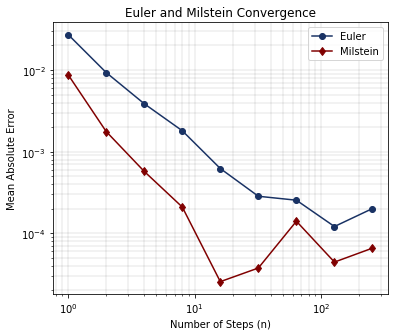

In [16]:
#Create a figure
fig = plt.figure(figsize = (6,5))

ax = fig.add_subplot(1,1,1)
ax.set_title('Euler and Milstein Convergence')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlabel('Number of Steps (n)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(which = 'both', linewidth = 0.1, color = 'k')
ax.plot(output_euler, label = 'Euler', color = '#193264', marker = 'o')
ax.plot(output_mil, label = 'Milstein', color = '#800000', marker = 'd')
ax.legend();

*Note that both axes are on a log-scale.*

The above figure shows that implementing the Milstein scheme improves the convergence rate and the accuracy of the discount bond price estimates compared to the Euler scheme. Moreover, the figure highlights the statistical noise that is evident when the mean absolute error becomes significantly small. 

Another thing worth mentioning is that it takes longer to generate the same amount of sample paths for the Milstein scheme compared to the Euler scheme due to the significantly larger equation to generate sample paths and thus an increase in the computation time when running the code. Thus, there is a trade-off between implementing shcemes of higher order compared to a simple scheme like the Euler scheme.

As a final remark, we note that due to the statistical noise, the comparison between the two schemes in terms of the convergence rate and the accuracy may not be as clear for a different set of simulated paths. 

## Concluding Remarks

In this model analysis project we have shown how to solve stochastic differential equations using Monte Carlo simulation. It is possible to get numerical estimates that are quite close to the theoretical value when implementing the simple Euler scheme. However, due to a low rate of convergence and possible bias in the Monte Carlo estimates, we have shown how the implementation of a second order discretization scheme, namely the Milstein scheme, can improve the speed of convergence and the accuracy of the numerical estimates. 

## References
* Andersen, L. (1995): Efficient Techniques for Simulation of Interest Rate
Models Involving Non-Linear Stochastic Differential
Equations, *General Re Financial Products, New York*

* Cox, J. C., Ingersoll, J. E. and Ross, S. A. (1985): A Theory of the Term Structure of Interest Rates, *Econometrica, Vol. 53, No. 2, pp. 385-407*

* Glasserman, P. (2004): Monte Carlo Methods in Financial Engineering, *Springer-Verlag, Vol. 53*

---